In [22]:
import os, cv2
from glob import glob
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy


In [2]:
new_images=sorted(glob("../new_data/*/images/*"))
new_masks=sorted(glob("../new_data/*/masks/*"))

In [3]:
newsize=(256,256)

x = []; y = []

    
for image, mask in zip(new_images, new_masks):
    img = Image.open(image)
    img=img.resize(newsize)
    pil_image = img.convert('RGB') 
    open_cv_image = np.array(pil_image) 
    img = open_cv_image[:, :, ::-1].copy() 
    x.append(img)
    x.append(cv2.flip(img, 0))
    x.append(cv2.flip(img, -1))
    x.append(cv2.flip(img, 1))
    msk = Image.open(mask)
    msk=msk.resize(newsize)
    pil_image = msk.convert('RGB') 
    open_cv_image = np.array(pil_image) 
    msk = open_cv_image[:, :, ::-1].copy()
    msk=cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    #msk = (cv2.threshold(cv2.imread(mask, 0),127,255,cv2.THRESH_BINARY)[1]//255.0).reshape(256,256,1)
    msk = (cv2.threshold(msk,127,255,cv2.THRESH_BINARY)[1]//255.0).reshape(256,256,1)
    y.append(msk)
    y.append(cv2.flip(msk, 0).reshape(256,256,1))
    y.append(cv2.flip(msk, -1).reshape(256,256,1))
    y.append(cv2.flip(msk, 1).reshape(256,256,1))
x = np.asarray(x)
y=np.asarray(y)
#x = np.asarray(x); y = np.asarray(y)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, shuffle = True, random_state = 42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle = True, random_state = 42) 
print('Data Split!')
print(len(x_train),len(x_test), len(x_valid))
print(x_train[0].shape, y_train[0].shape)
del x; del y

Data Split!
7702 2202 1100
(256, 256, 3) (256, 256, 1)


In [5]:
print("Validation shapes:", x_valid.shape, y_valid.shape)
print("Test shapes:", x_test.shape, y_test.shape)
print("Train shapes:", x_train.shape, y_train.shape)

Validation shapes: (1100, 256, 256, 3) (1100, 256, 256, 1)
Test shapes: (2202, 256, 256, 3) (2202, 256, 256, 1)
Train shapes: (7702, 256, 256, 3) (7702, 256, 256, 1)


In [ ]:
opt = Adam(learning_rate=2e-4)

# Define the model
model = r2_unet(256, 256, 1)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

# initial_epochs = 10  # Reduced from 500 for initial testing
# small_batch_size = 16  # Reduced from 32 to lessen memory load

results = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                    batch_size=small_batch_size, epochs=initial_epochs, verbose=2,
                    callbacks=[ModelCheckpoint('partial_model_070622.keras', save_best_only=True, monitor='val_mean_io_u_2', mode='max'),
                               CSVLogger("partial_history_070622.csv", separator=",", append=False)])
# results = model.fit(x_train[:100], y_train[:100], validation_data=(x_valid[:100], y_valid[:100]),
#                     batch_size=small_batch_size, epochs=initial_epochs, verbose=2,
#                     callbacks=[ModelCheckpoint('partial_model_070622.keras', save_best_only=True, monitor='val_mean_io_u_2', mode='max'),
#                                CSVLogger("partial_history_070622.csv", separator=",", append=False)])

In [12]:
opt=tf.keras.optimizers.Adam(learning_rate=2e-4)
model1=r2_unet(256, 256, 1)
model1.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2),f1_metric])

In [14]:
model1.load_weights('./complete_model(35k).h5')

In [23]:
predictions = model1.predict(x_train)

loss_function = BinaryCrossentropy()
loss = loss_function(y_train, predictions).numpy()

accuracy_metric = BinaryAccuracy()
accuracy_metric.update_state(y_train, predictions)
accuracy = accuracy_metric.result().numpy()

print("Manually computed Loss:", loss)
print("Manually computed Accuracy:", accuracy)

241/241 ━━━━━━━━━━━━━━━━━━━━ 703s 3s/step
Manually computed Loss: 0.13878487
Manually computed Accuracy: 0.9840849


In [25]:
predictions = model1.predict(x_test)

loss_function = BinaryCrossentropy()
loss = loss_function(y_test, predictions).numpy()

accuracy_metric = BinaryAccuracy()
accuracy_metric.update_state(y_test, predictions)
accuracy = accuracy_metric.result().numpy()

print("Manually computed Loss:", loss)
print("Manually computed Accuracy:", accuracy)

69/69 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step
Manually computed Loss: 0.14448681
Manually computed Accuracy: 0.983483


In [24]:
predictions = model1.predict(x_valid)

loss_function = BinaryCrossentropy()
loss = loss_function(y_valid, predictions).numpy()

accuracy_metric = BinaryAccuracy()
accuracy_metric.update_state(y_valid, predictions)
accuracy = accuracy_metric.result().numpy()

print("Manually computed Loss:", loss)
print("Manually computed Accuracy:", accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step
Manually computed Loss: 0.1350836
Manually computed Accuracy: 0.9843441


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/var/folders/s3/gbs_vnk57ln9xq97wtgt2s4w0000gn/T/ipykernel_3566/33417974.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20,20))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


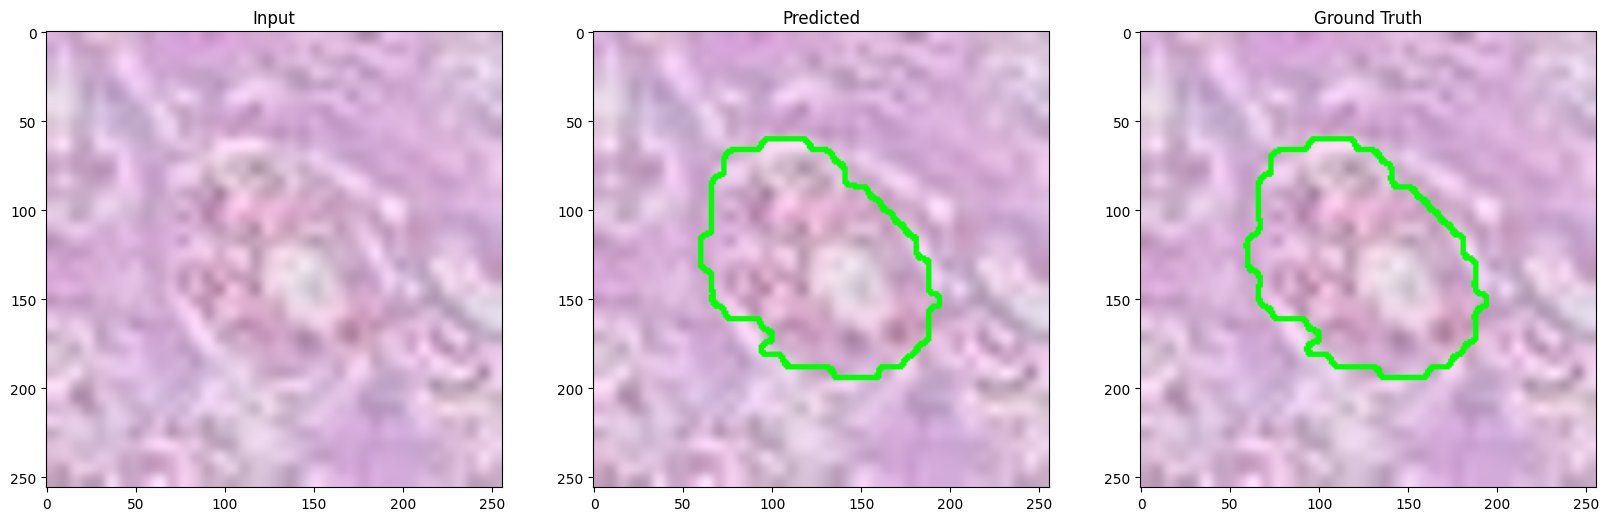

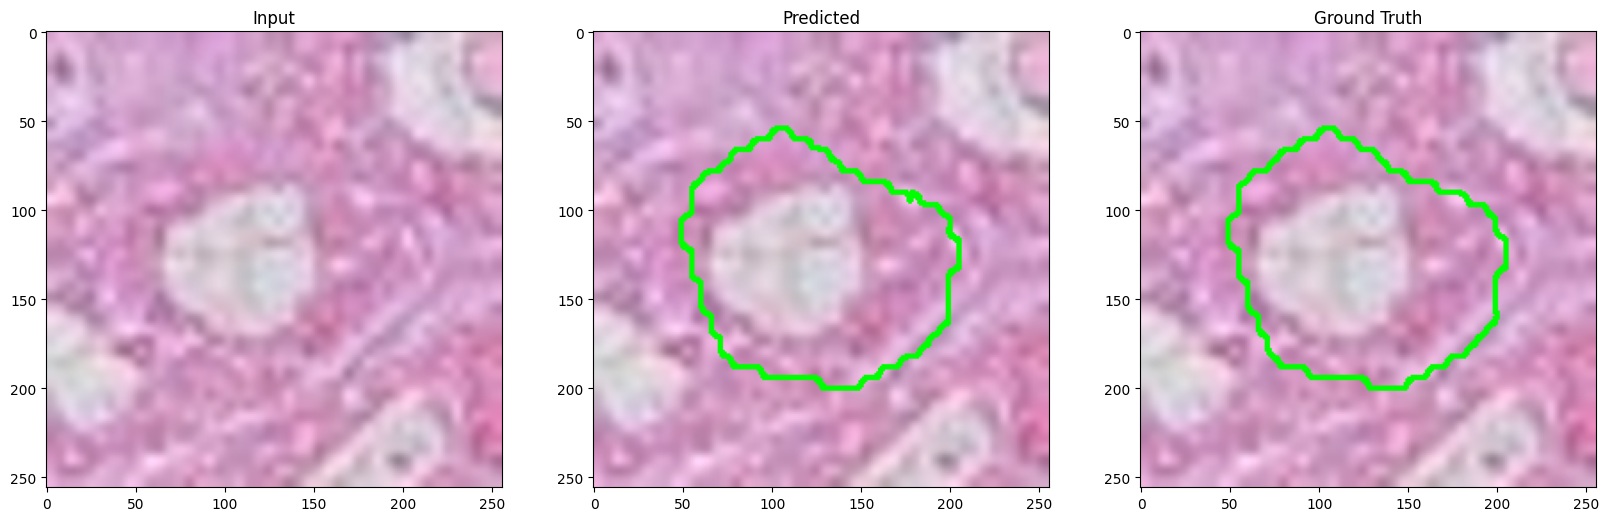

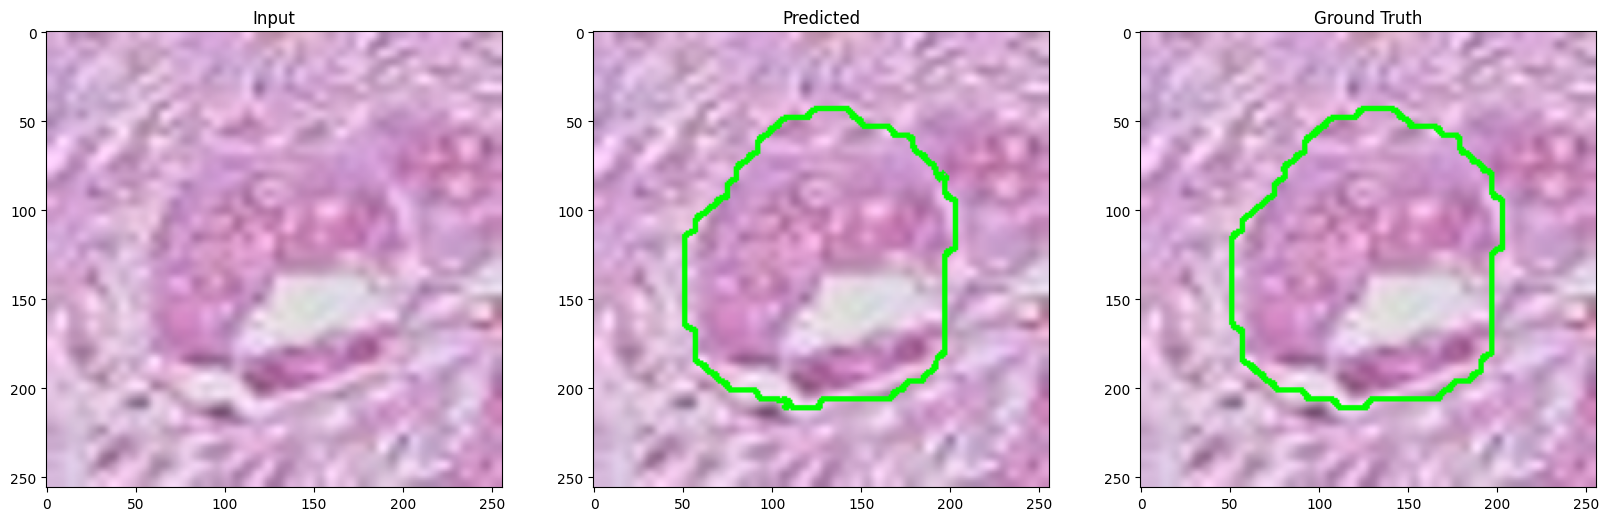

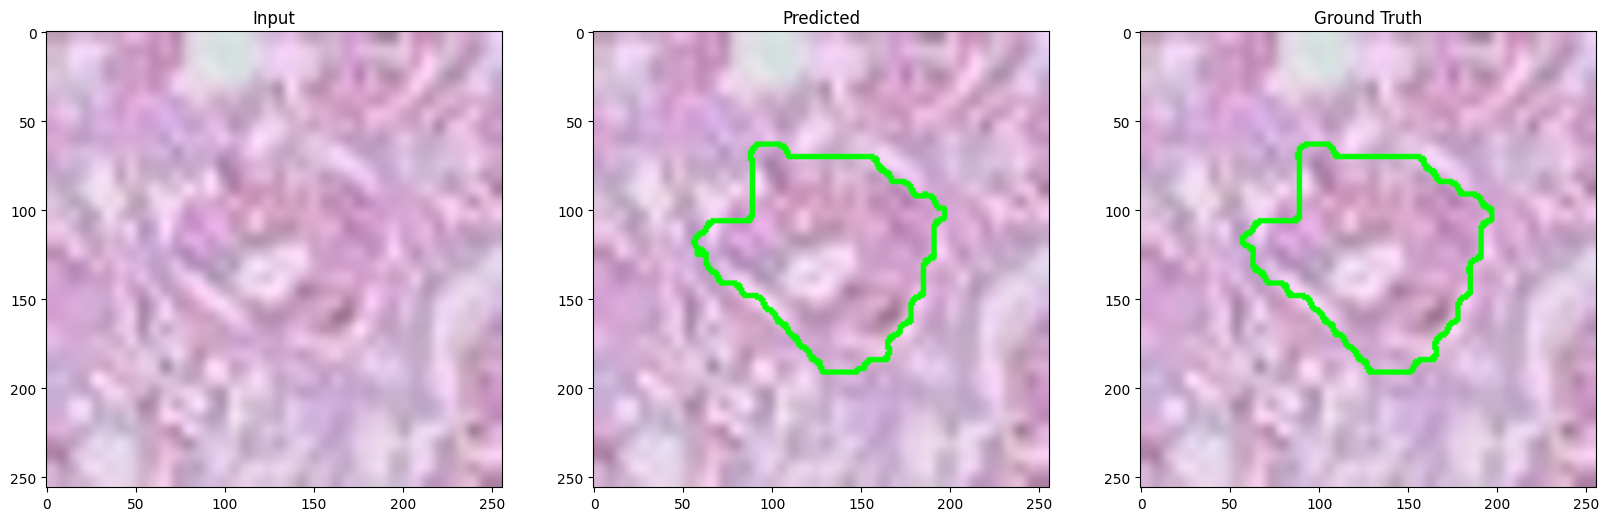

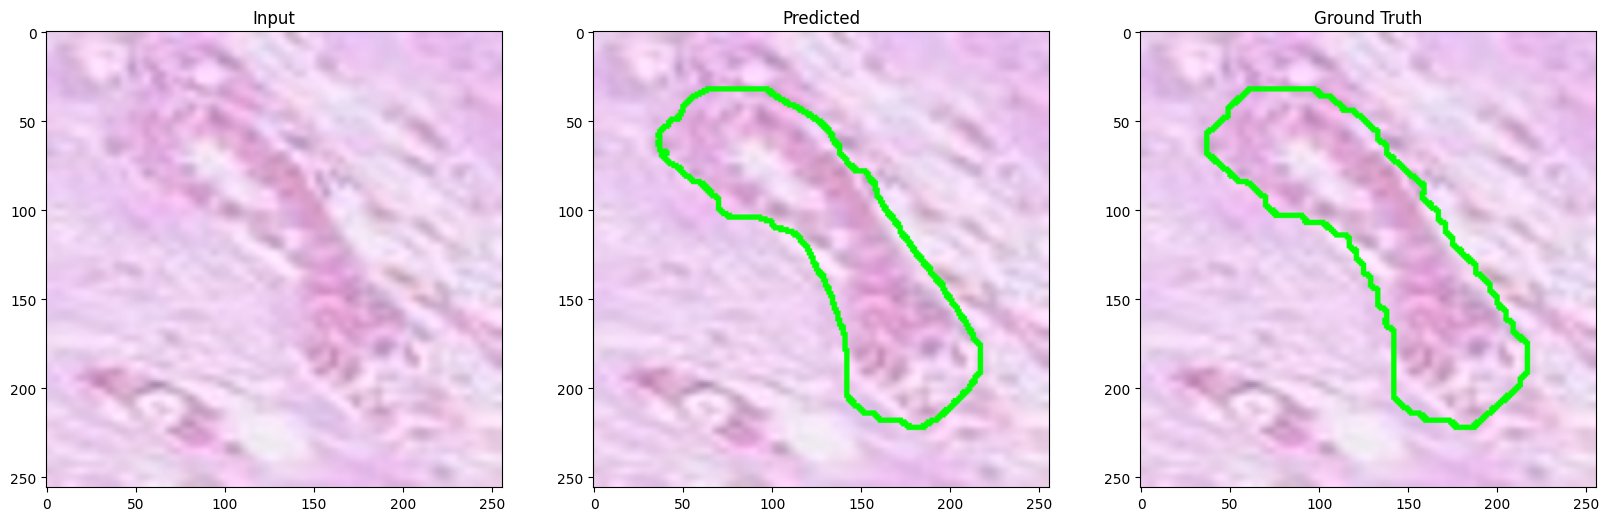

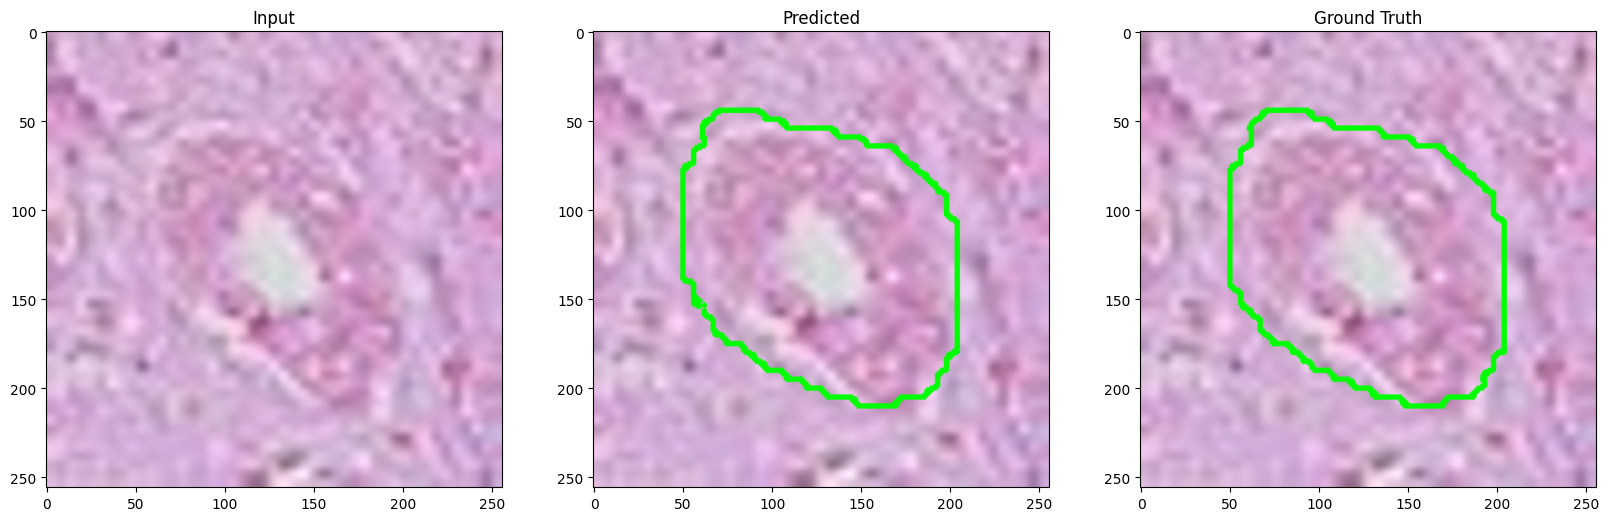

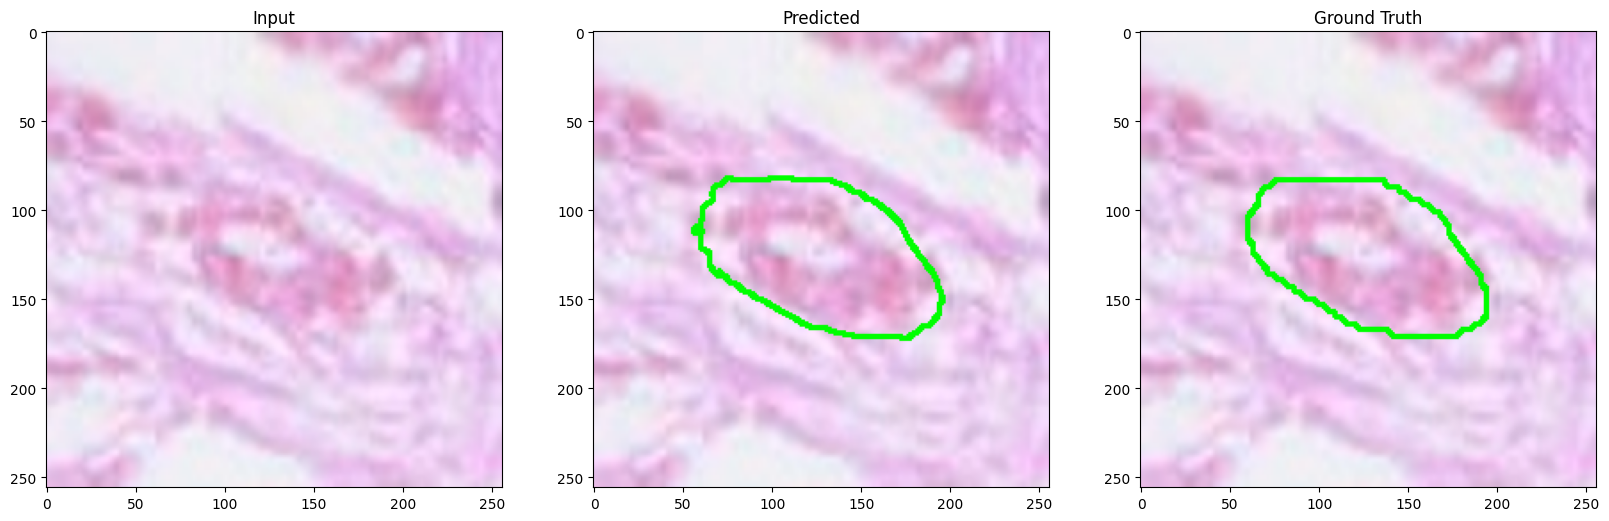

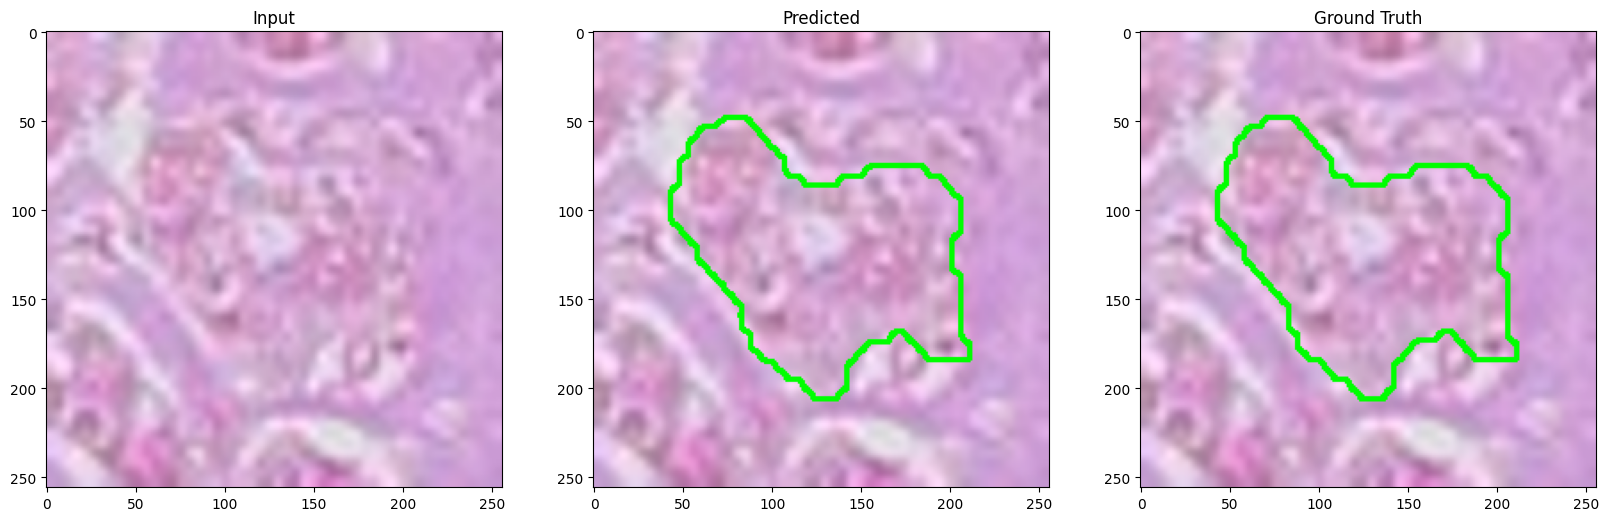

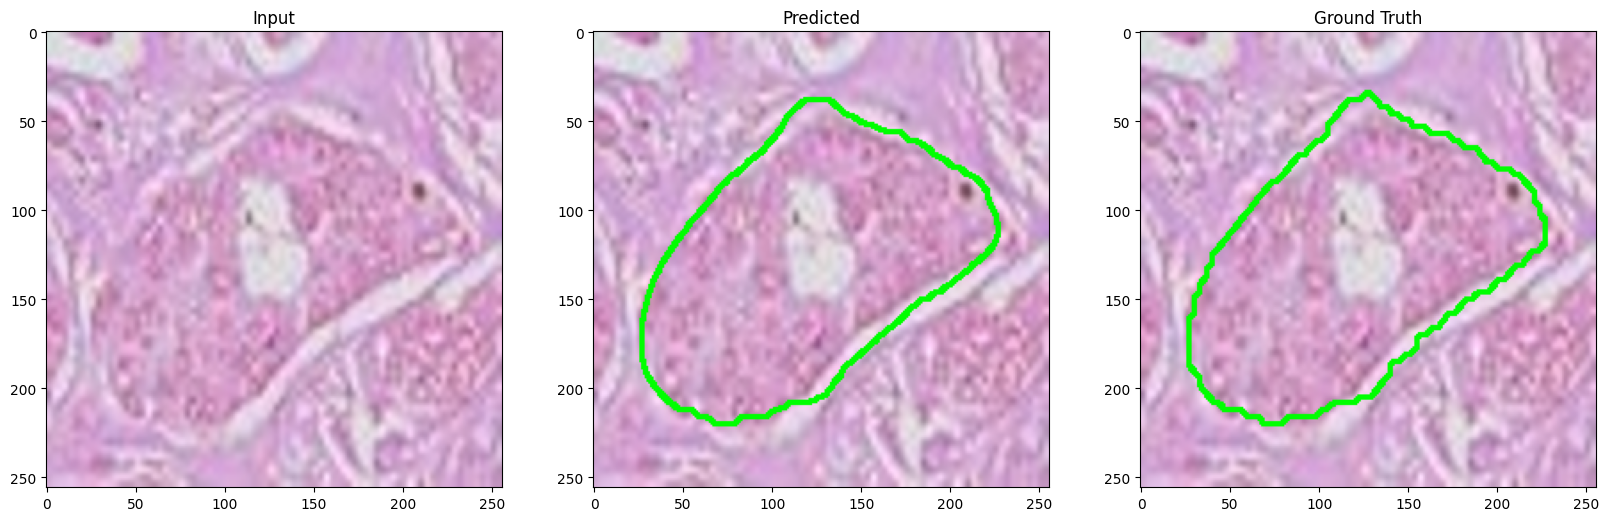

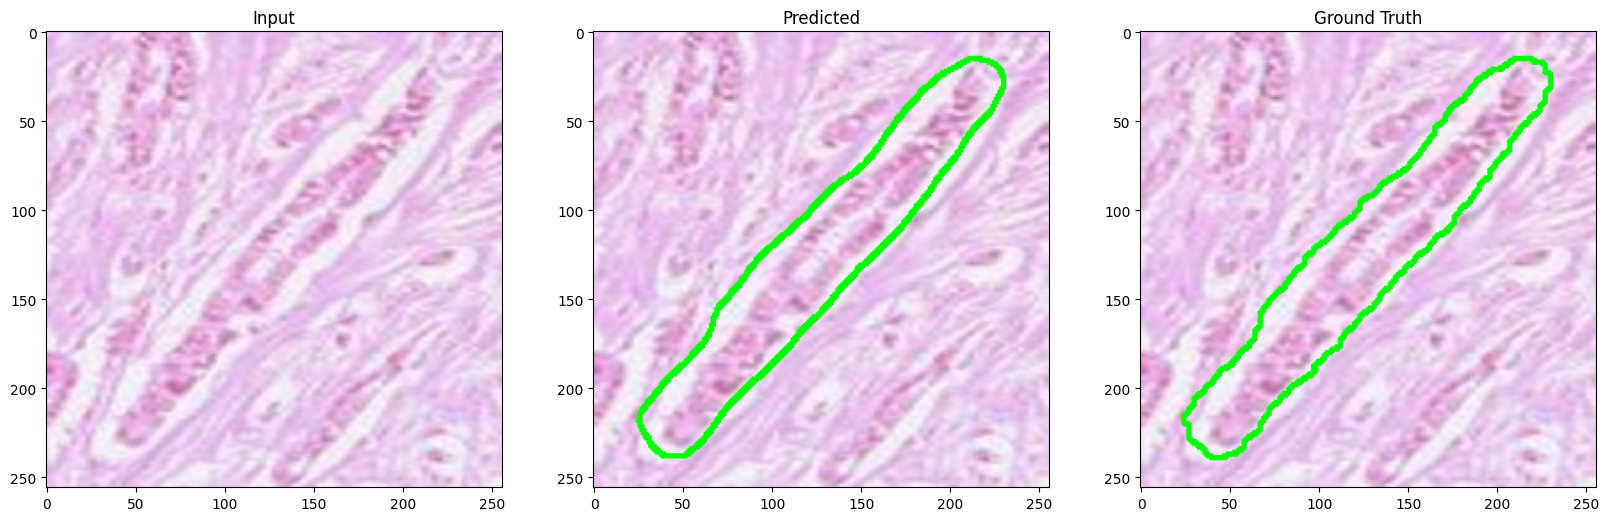

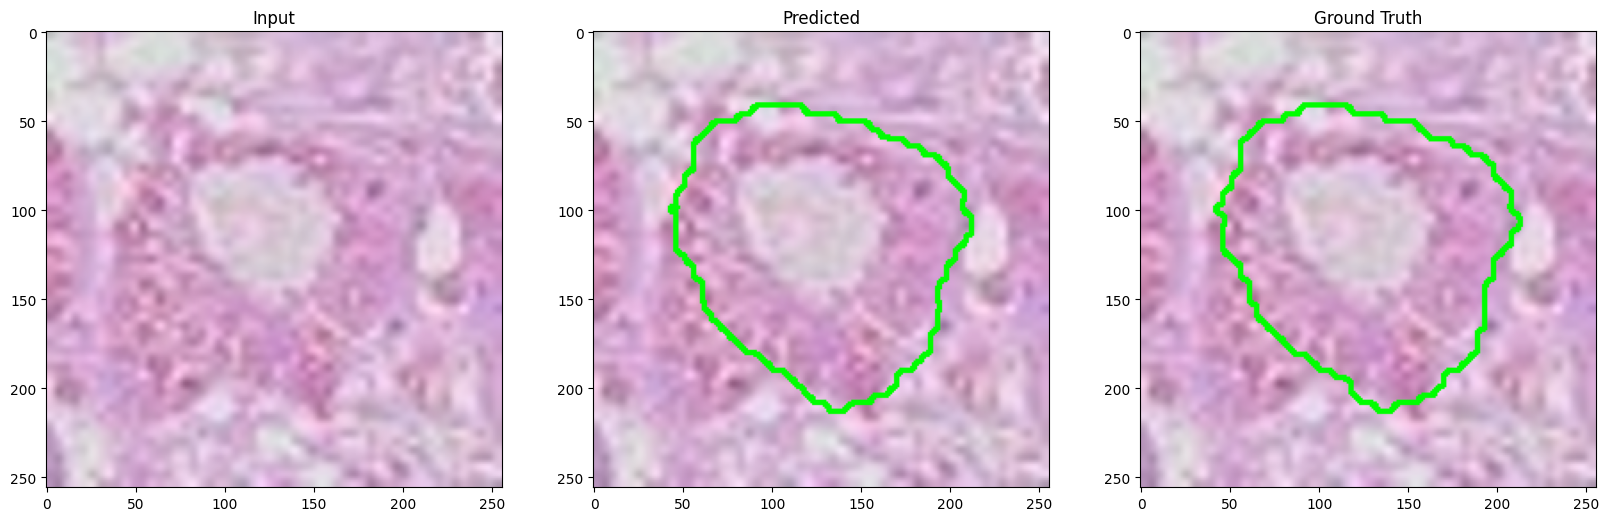

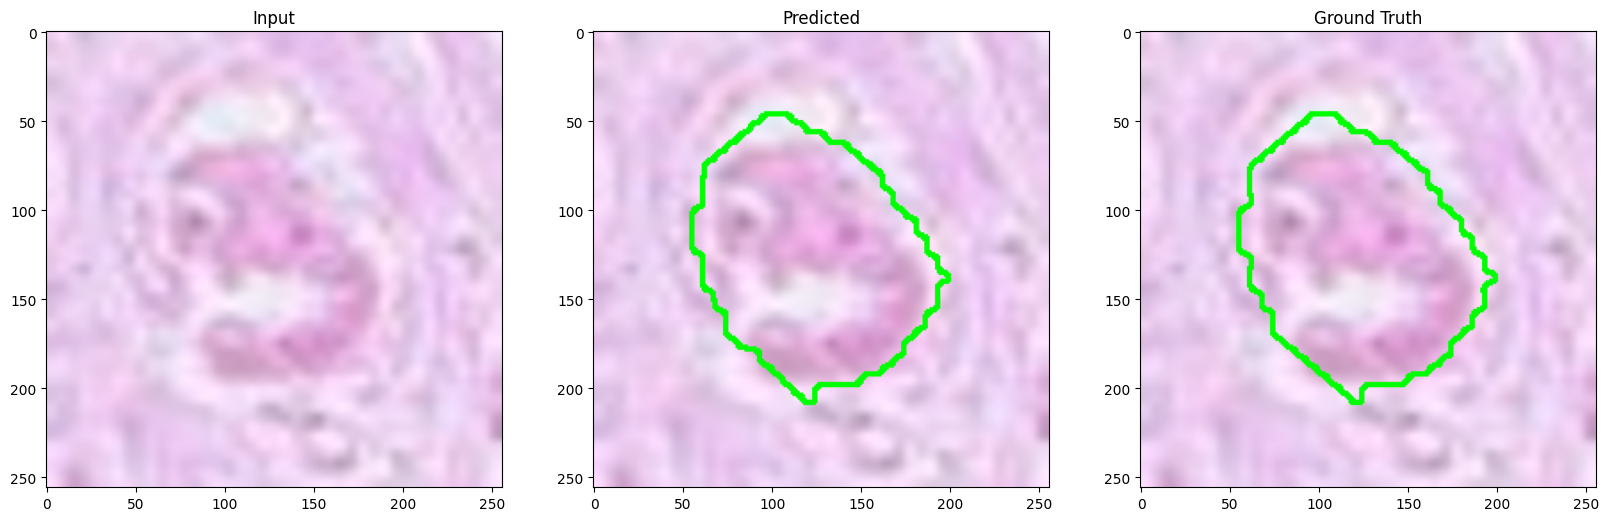

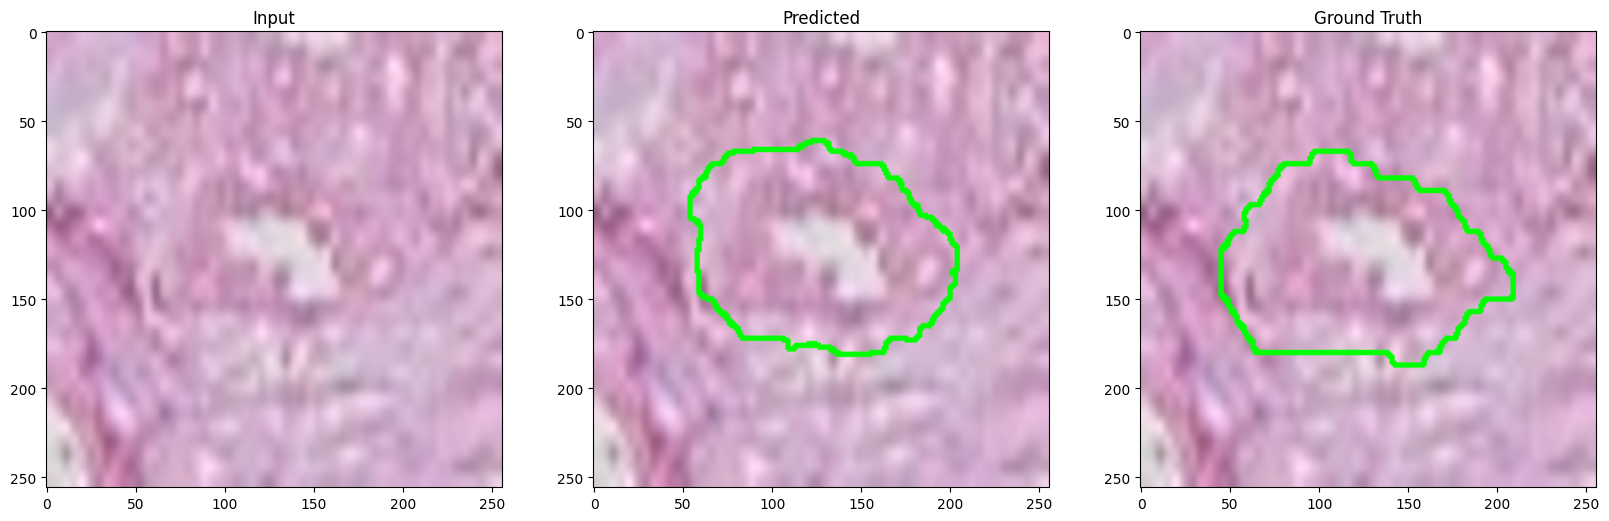

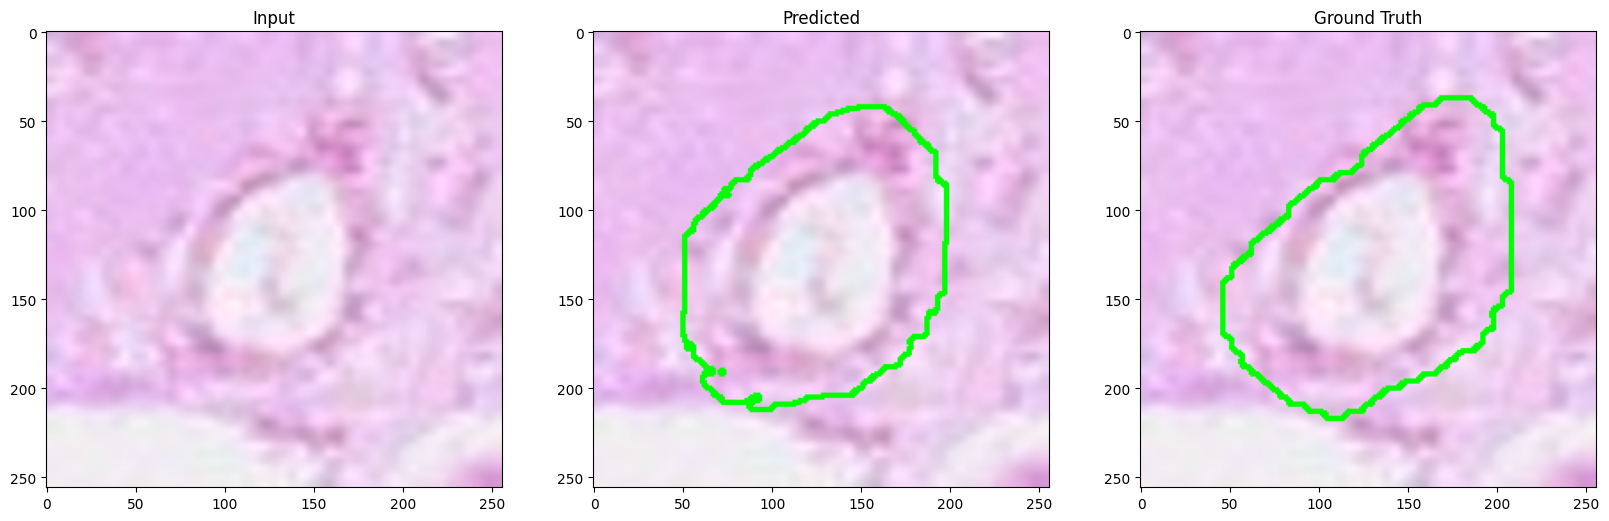

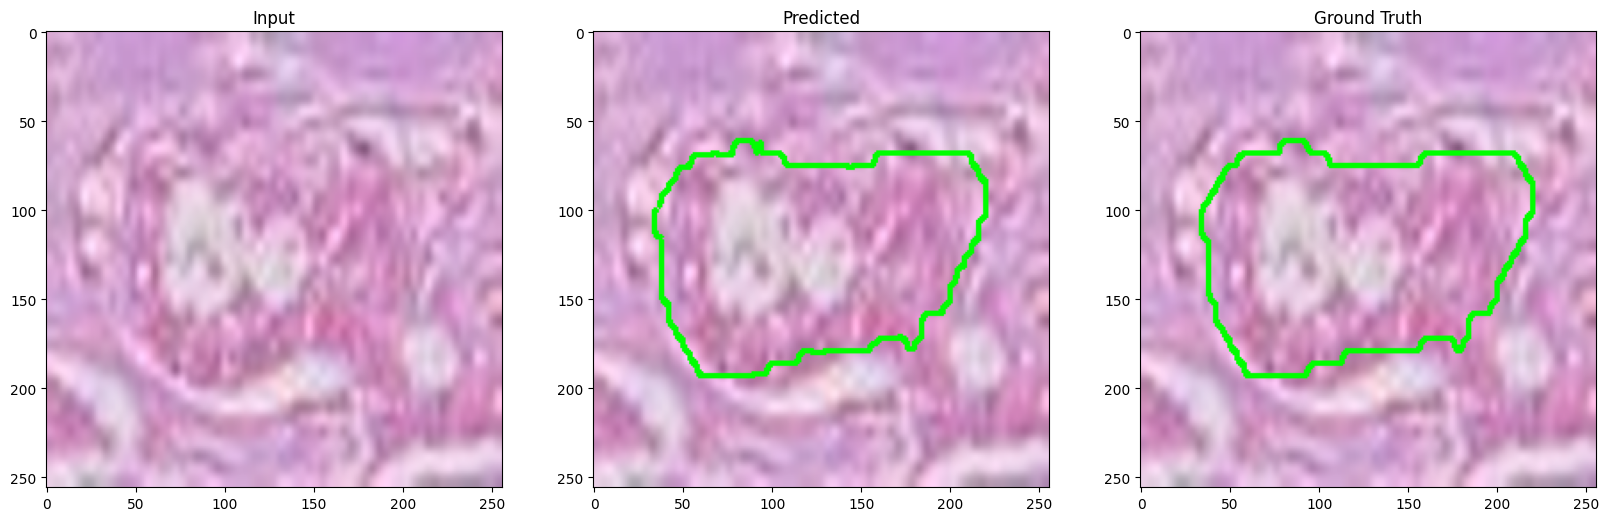

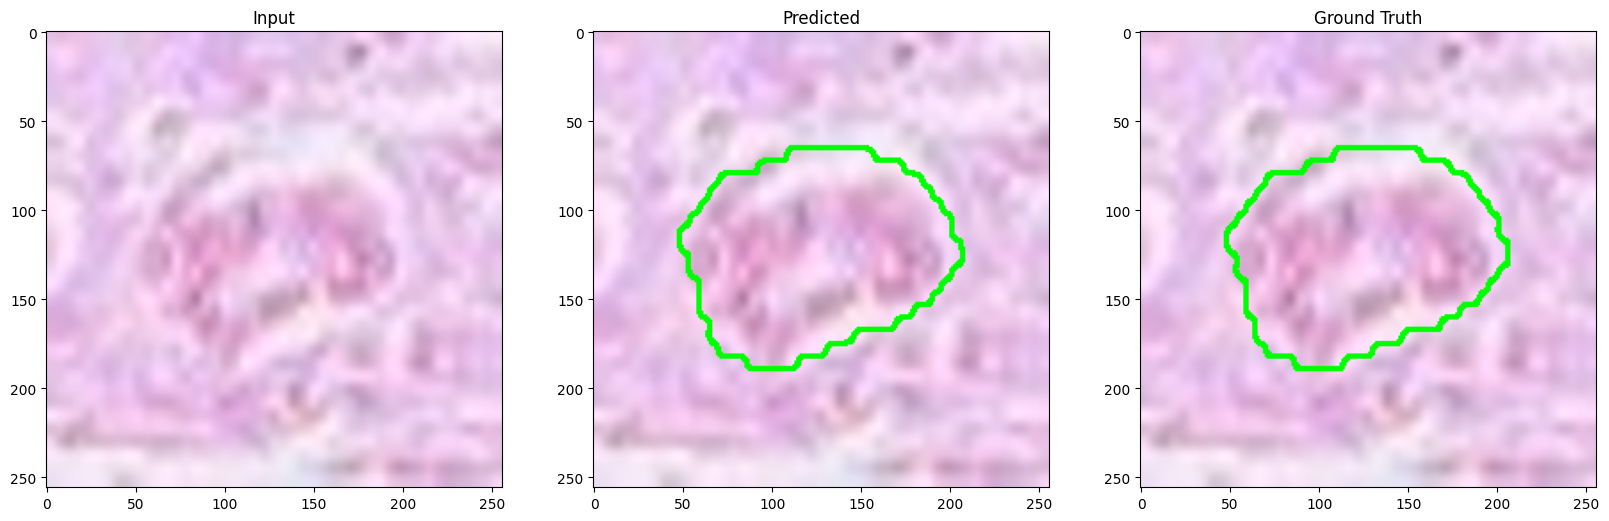

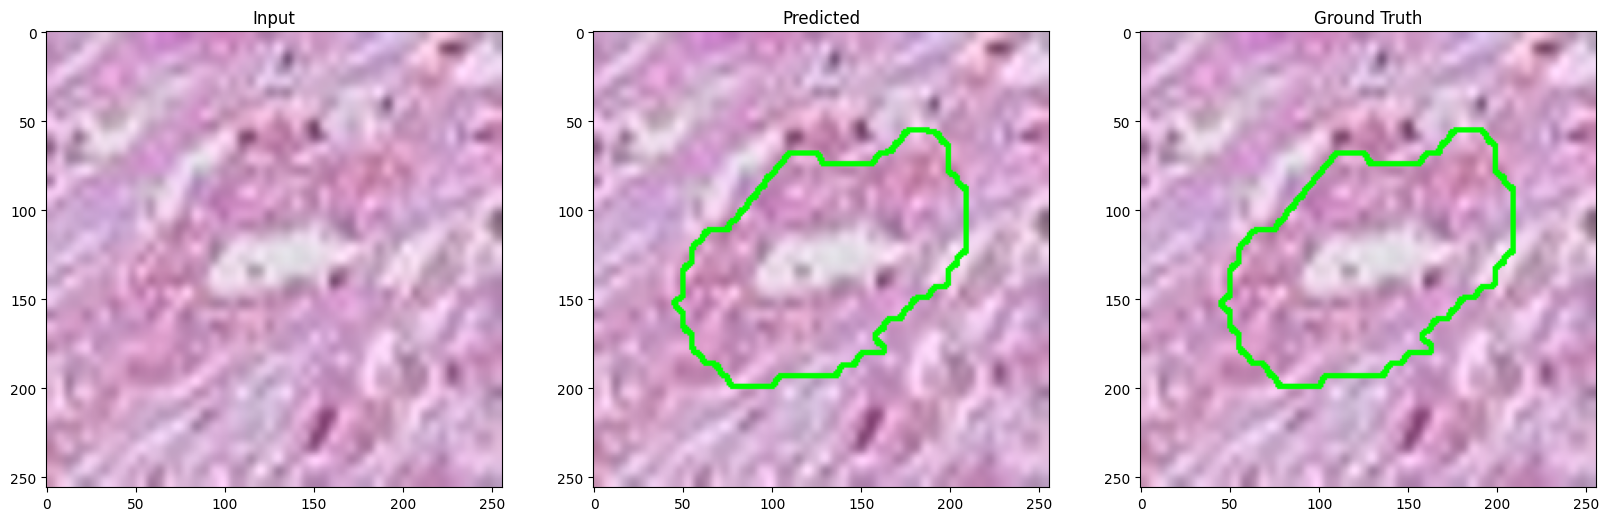

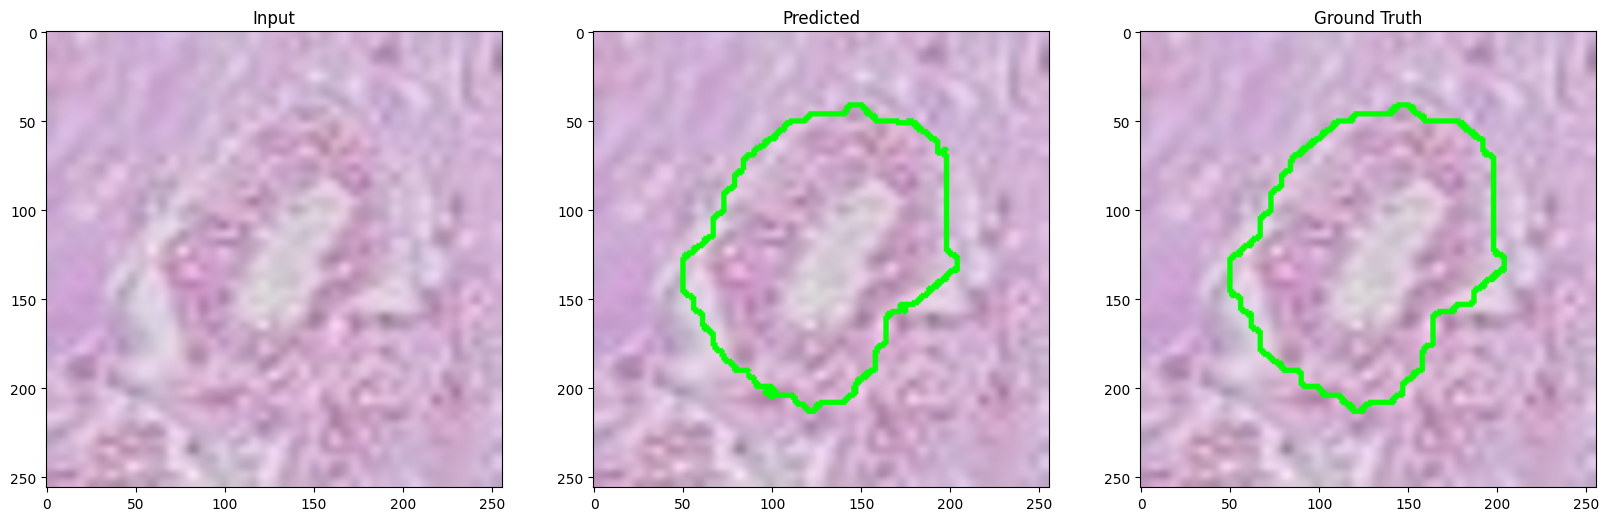

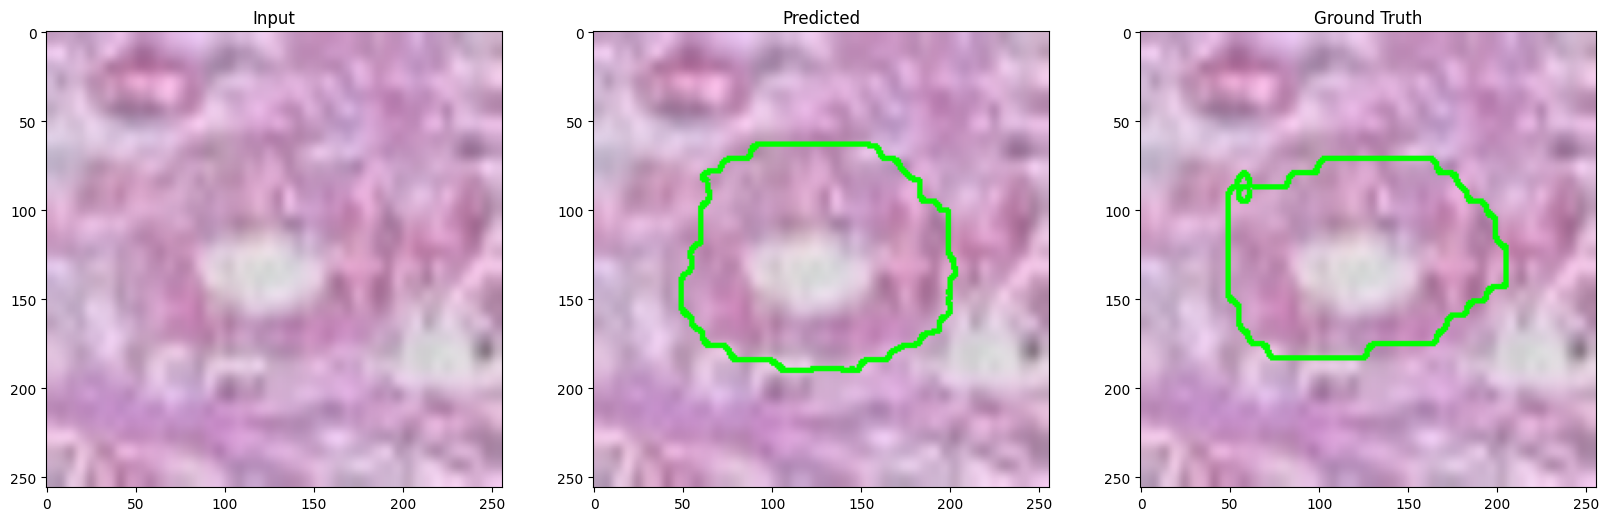

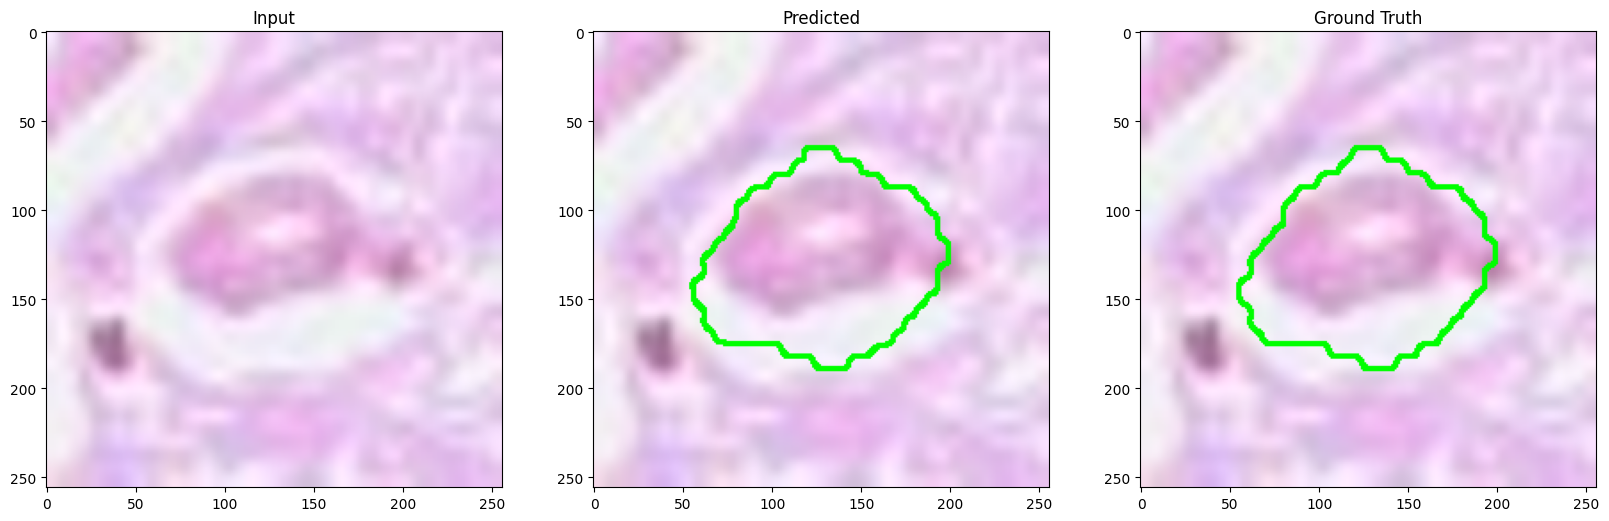

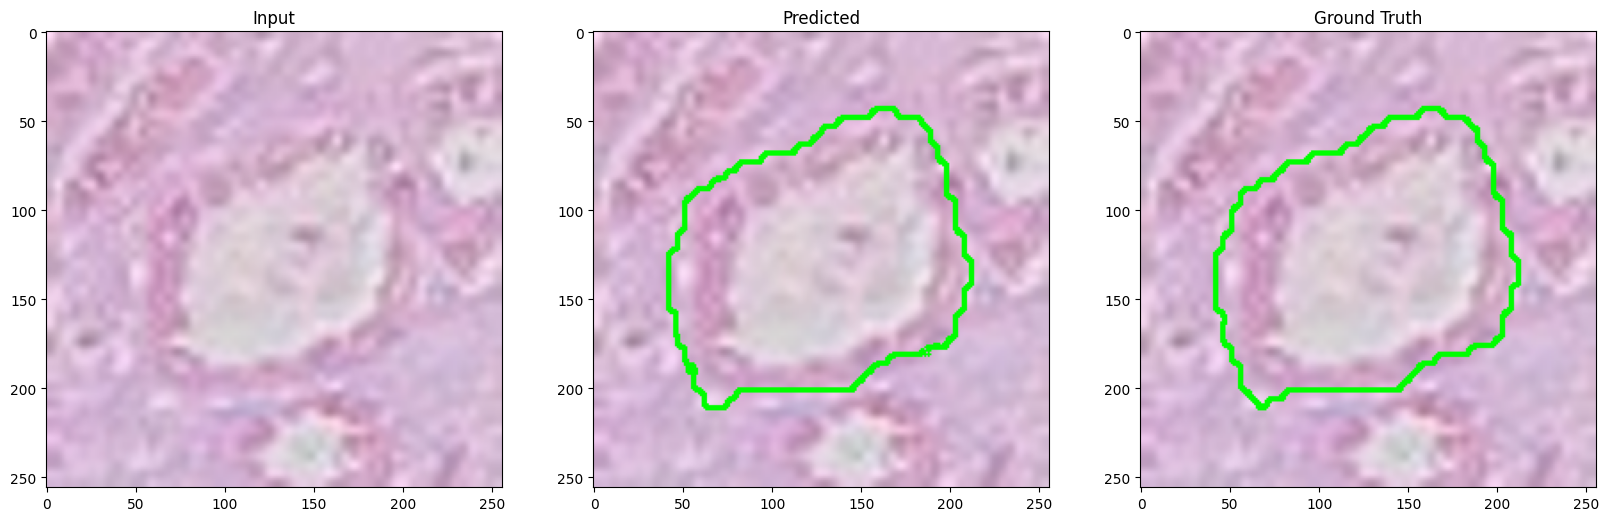

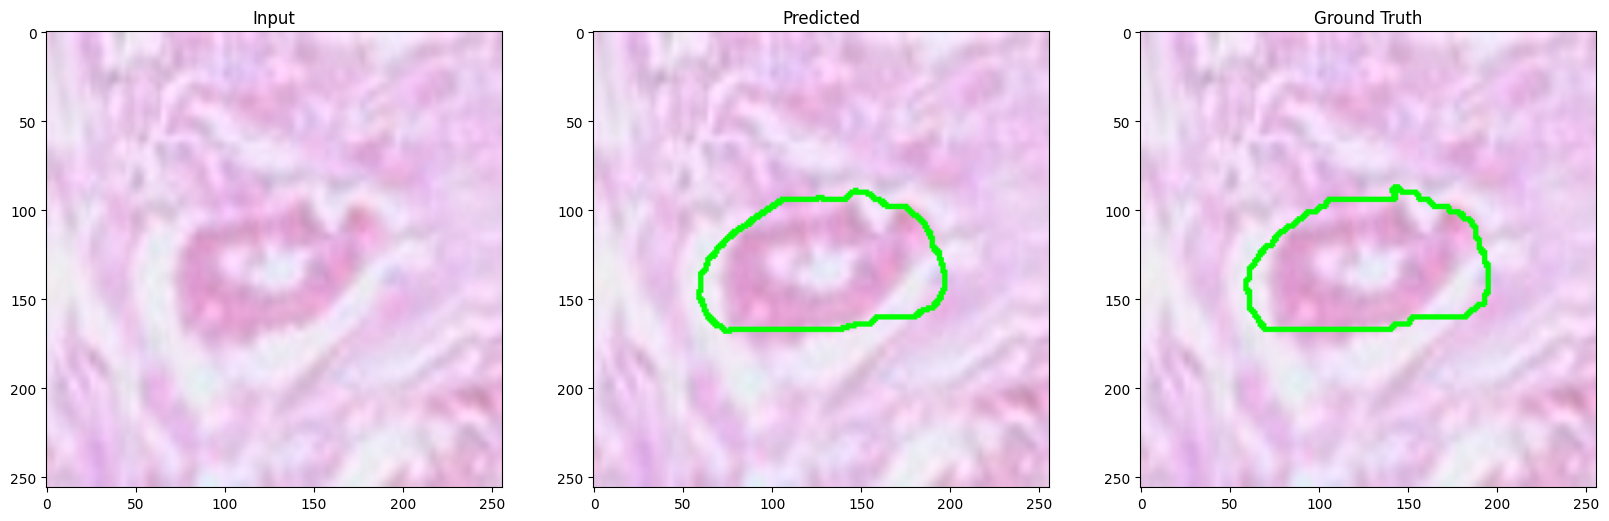

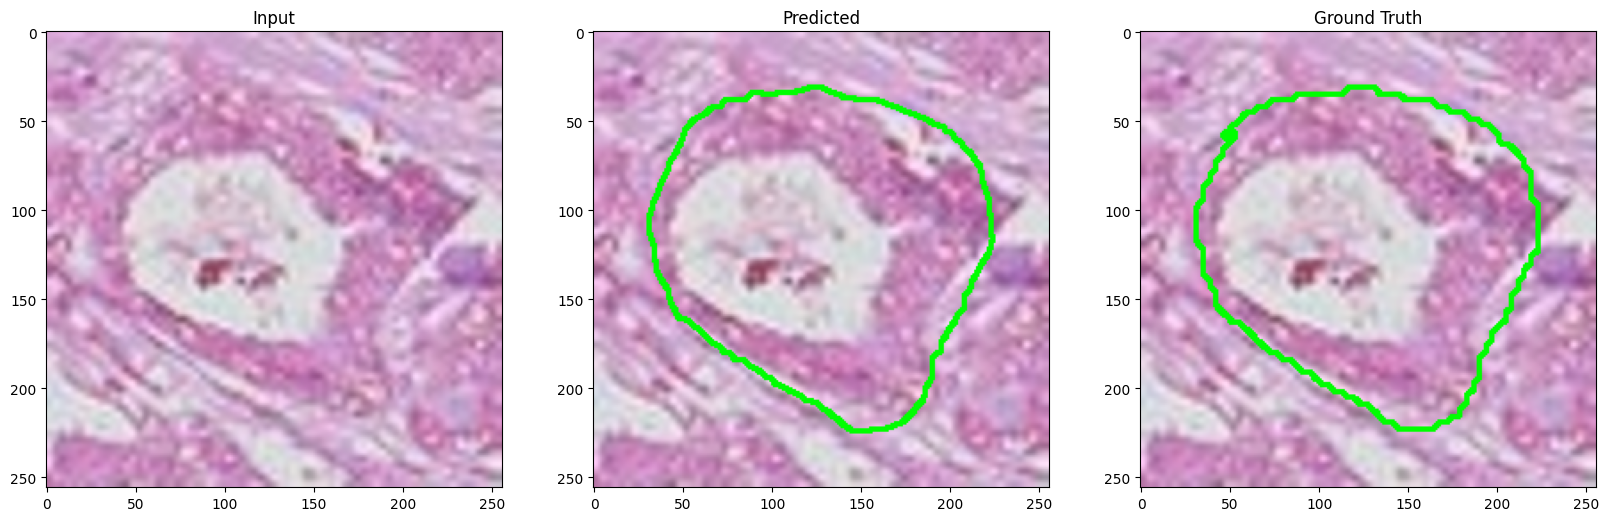

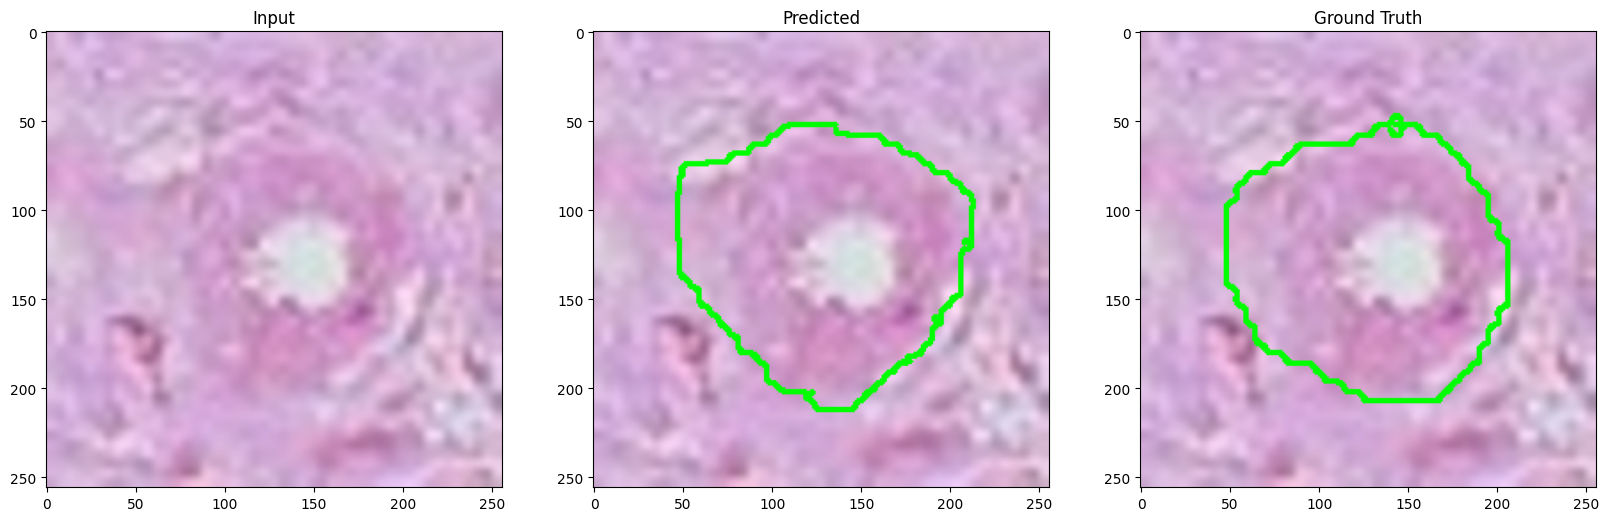

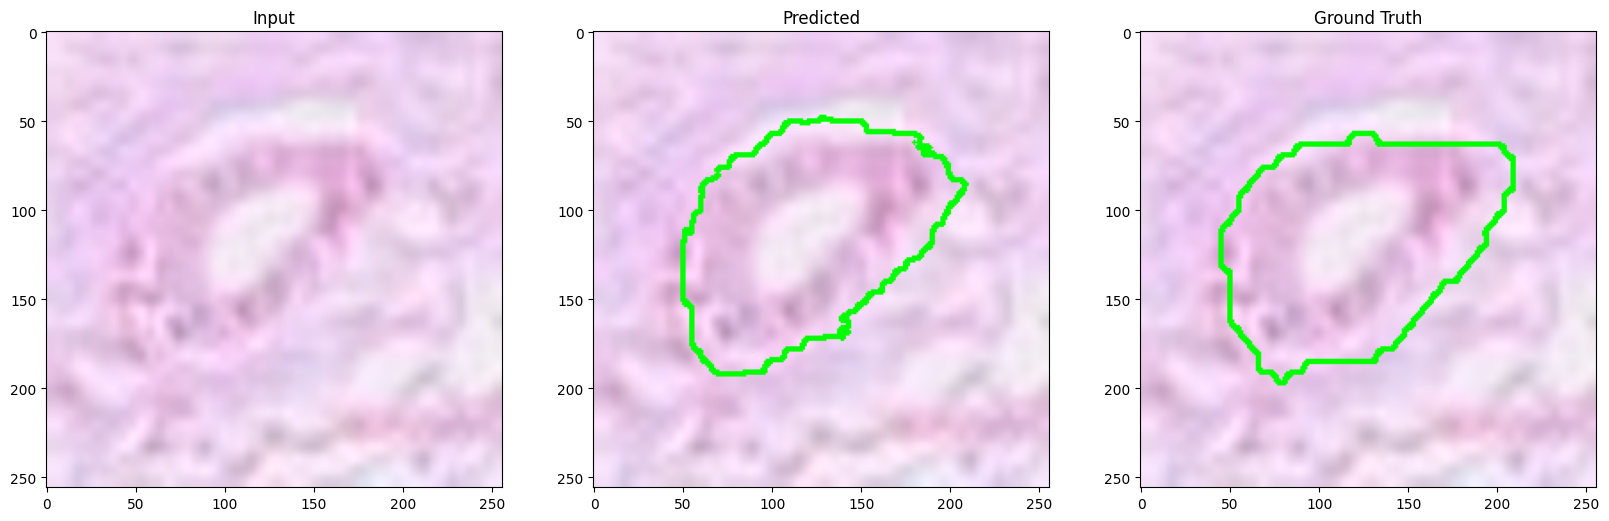

In [21]:
X_Test = x_test.copy()
Y_Test = y_test.copy()
for i in range(25):
    i1 = X_Test[i].copy()
    i2 = X_Test[i].copy()
    fig = plt.figure(figsize=(20,20))
    a = fig.add_subplot(1,3,1)
    a.title.set_text('Input')
    a.imshow(X_Test[i])
    a = fig.add_subplot(1,3,2)
    pred_mask = model1.predict(i1.reshape(1,256,256,3)).reshape(256,256)
    _,pred_mask = cv2.threshold(pred_mask,0.4,1,cv2.THRESH_BINARY)
    pred_mask *= 255
    pred_mask = pred_mask.astype(np.uint8)
    a.title.set_text('Predicted')
    a.imshow(contour_img(X_Test[i].copy(), pred_mask))
    a = fig.add_subplot(1,3,3)
    a.title.set_text('Ground Truth')
    a.imshow(contour_img(X_Test[i].copy(), Y_Test[i].copy()*255))